In [ ]:
# predicts expression of the test data with the trained and random networks
# predicts expression of MelBrainSys data
# creates correlation plots of these predicted and original expression:
#   Figure-2-gene-expr-prediction-correl.png

In [1]:
library(ggplot2)
library(gridExtra)
library(parallel)

In [2]:
basePath = "/data/bcu_projects/MelBrainSys_PostdocProject_Gruetzmann/publications/2022-my-MelBrainSys-paper/scripts-etc-for-publication/"
myPath = paste0(basePath,"regNet/")

In [3]:
localRlibs = paste0(basePath,"conda/lib/R/library/")
library(regNet)

Loading required package: glmnet

Loading required package: Matrix

Loaded glmnet 4.1-6

Loading required package: lars

Loaded lars 1.3


Loading required package: covTest

Loading required package: glmpath

Loading required package: survival

Loading required package: MASS



In [4]:
setwd(myPath)

In [5]:
outDirectory = paste0(basePath,"FiguresTables/")

In [8]:
output=T
networkName = "TcgaMelanomaExprMeth"

In [36]:
localGeneCutoff = 30
pValCutoff = 0.001
nbCPUs = 10 
numOfNWs = 2 # for test purposes only 2 networks. Hence note, the results can deviate from the paper.
numRandNWinstances = 2
dataSetsPath = "Data/"

### create random networks

In [11]:
# random network instance is saved
# under NetworkModel/WholeNetwork/ using a pre-defined file-naming convention with random
# network name prefix paste0( "RandomNetwork_", randomNetworkInstance, 
#  "_PVal-ueCutoff_", pValCutoff, "_BasedOn_", networkName )

create1randomNW = function(parameterSet) {
    system(paste("echo 'calculating set:",parameterSet$runningNumber,"'")) 
     #  -> progress output in console where you started jupyter notebook
    determineRandomNetworkWithFilteringForSignificantPredictors(output = T,
        networkName = parameterSet$networkName, pValCutoff =  parameterSet$pValCutoff, 
        randomNetworkInstance = parameterSet$nwInstanceNb, 
        path = parameterSet$path )
}

In [12]:
# make parameter sets for creation of random nw:
randNWinstancesRange = 1:numRandNWinstances
nwRange = 1:numOfNWs
parameterSets = NULL
i=0
for(nwInstanceNb in randNWinstancesRange ) {
    for(nwSubdir in paste0("TrainNetwork-",nwRange)) {
        i = i + 1
        parameterSets[[i]] = list(networkName=networkName,pValCutoff=pValCutoff,
                                path = nwSubdir, runningNumber=i, nwInstanceNb = nwInstanceNb)
    }
}

In [11]:
startt = Sys.time()
tmp = mclapply(X = parameterSets, create1randomNW, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt
# 1 min with 10 cpus for 2 nw instances, 2 trained networks

Time difference of 1.221554 mins

### predict gene expression with trained and thereof derived random networks
outputs created in TrainNetwork-*/NetworkPrediction/

In [14]:
# n.b. already parallelized, don't over-parallelize, and uses 1.5% of RAM
predict1nw = function(parameterSet) {
    system(paste("echo 'calculating set:",parameterSet$runningNumber,"'"))
    
    geneExFile = parameterSet$dataSetExpr
    geneMthFile = parameterSet$dataSetMethyl
    system(paste0("echo 'using: ",dataSetsPath,geneExFile," and ",dataSetsPath,geneMthFile,"'"))

    if(! file.exists(paste0(dataSetsPath,geneExFile))) {
        system(paste0("echo 'does not exist: ",dataSetsPath,geneExFile,"'"))
    }
    if(! file.exists(paste0(dataSetsPath,geneMthFile))) {
        system(paste("echo 'does not exist:",dataSetsPath,geneMthFile,"'"))
    }
    testDataSet = loadGeneExpressionAndCopyNumberDataSet( geneExpressionFile = geneExFile,
        geneCopyNumberFile = geneMthFile, path = dataSetsPath )
    predictGeneExpression(data = testDataSet, dataSetName = parameterSet$dataSetName, 
                          networkName = parameterSet$networkName, pValCutoff = parameterSet$pValCutoff, 
                          localGeneCutoff = parameterSet$localGeneCutoff, path = parameterSet$trainNWpath )
}

In [16]:
# create parameter sets for prediction with trained networks
createNormalPredictionSets = function(networkName,dataSetName,
                                pValCutoffs,localGeneCutoffs,nwRange) {
    parameterSets = NULL
    i=0
    for (pValCutoff in pValCutoffs) {
        for (localGeneCutoff in localGeneCutoffs) {
            for (networkNum in nwRange) {
                i = i + 1
                geneExFile = paste0(dataSetName, "_ExpressionData_regNet_Run_",networkNum,".txt")
                geneMthFile = paste0(dataSetName , "_MethylationData_regNet_Run_",networkNum,".txt")
                parameterSets[[i]] = list(dataSetExpr = geneExFile, dataSetMethyl = geneMthFile,
                                          dataSetName = dataSetName, networkName=networkName,
                                          pValCutoff=pValCutoff,localGeneCutoff = localGeneCutoff, 
                                         trainNWpath = paste0("TrainNetwork-",networkNum),runningNumber=i)
            }
        }

    }
    return(parameterSets)
}

In [17]:
# create parameter sets for prediction with random networks
## for each of the trained networks there will be several random networks
createRandomPredictionSets = function(networkName,randomNameBase,dataSetName,
                                pValCutoffs,localGeneCutoffs,numNWinstanceRange,nwRange) {
    parameterSets = NULL
    i=0
    for (nwInstanceNb in numNWinstanceRange ) {
        for (pValCutoff in pValCutoffs) {
            for (localGeneCutoff in localGeneCutoffs) {
                for (networkNum in nwRange) {
                    i = i + 1
                    randomNetworkName = paste0(randomNameBase,nwInstanceNb,"_PValueCutoff_",pValCutoff,
                                               "_BasedOn_",networkName)
                    geneExFile = paste0(dataSetName, "_ExpressionData_regNet_Run_",networkNum,".txt")
                    geneMthFile = paste0(dataSetName , "_MethylationData_regNet_Run_",networkNum,".txt")
                    parameterSets[[i]] = list(dataSetExpr = geneExFile, dataSetMethyl = geneMthFile,
                                              dataSetName = dataSetName, networkName=randomNetworkName,
                                              pValCutoff=pValCutoff,localGeneCutoff = localGeneCutoff, 
                                             trainNWpath = paste0("TrainNetwork-",networkNum),runningNumber=i)
                }
            }
           
        }
    }
    return(parameterSets)
}

In [18]:
# parameter sets for prediction of test data with normal networks:
parameterSetsNormal = 
    createNormalPredictionSets(networkName = networkName,dataSetName = "TestSet", 
                               pValCutoffs = 0.001, localGeneCutoffs = 30, nwRange = 1:numOfNWs)

In [22]:
# parameter sets for prediction of random nteworks:
networkNameBase = "RandomNetwork_" 
parameterSetsRandom = 
    createRandomPredictionSets(networkName = networkName, randomNameBase = "RandomNetwork_",
                         dataSetName = "TestSet", pValCutoffs =  0.001,
                         localGeneCutoffs = 30, numNWinstanceRange = 1:numRandNWinstances, nwRange = 1:numOfNWs)

In [25]:
# parameter sets for prediction of MelBrain Data with TCGA trained:
parameterSetsMelBrainSys = 
    createNormalPredictionSets(networkName = networkName,
                         dataSetName = "MelBrainSys", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)

In [26]:
# rename melBrainSys data sets, they don't follow the TrainNetwok number:
parameterSetsMelBrainSys[[1]]$dataSetExpr
parameterSetsMelBrainSys[[1]]$dataSetMethyl

for(i in 1:length(parameterSetsMelBrainSys)) {
    parameterSetsMelBrainSys[[i]]$dataSetExpr = "MelBrainSys-expression.csv"
    parameterSetsMelBrainSys[[i]]$dataSetMethyl = "MelBrainSys-methylation.csv"
}

[1] "MelBrainSys_ExpressionData_regNet_Run_1.txt"

[1] "MelBrainSys_MethylationData_regNet_Run_1.txt"

In [33]:
# predict test data with trained network:
startt = Sys.time()
tmp = mclapply(X = parameterSetsNormal, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt
# 35 sec with 19 cpus for 2 data sets (2 NWs each 1 NW instances)

Time difference of 33.88182 secs

In [35]:
# predict test data with random networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsRandom, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt
# 39 sec with 19 cpus for 2 data sets (2 NWs each 2 NW instances)

Time difference of 38.23217 secs

In [47]:
# predict MelBrainSys data with trained networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSys, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt
# 24 sec with 19 cpus for 2 data sets (2 NWs each 1 NW instances)

Time difference of 23.92259 secs

In [46]:
# parameter sets for prediction of MelBrain BRAIN Data with TCGA trained:
parameterSetsMelBrainSysBrain = 
    createNormalPredictionSets(networkName = networkName,
                         dataSetName = "MelBrainSysBrain", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)
# rename data sets:
for(i in 1:length(parameterSetsMelBrainSysBrain)) {
    parameterSetsMelBrainSysBrain[[i]]$dataSetExpr = "MelBrainSysBrainSamples-expression.csv"
    parameterSetsMelBrainSysBrain[[i]]$dataSetMethyl = "MelBrainSysBrainSamples-methylation.csv"
}

In [48]:
# parameter sets for prediction of MelBrain EXTRACRANIAL Data with TCGA trained:
parameterSetsMelBrainSysECM = 
    createNormalPredictionSets(networkName = networkName,
                         dataSetName = "MelBrainSysECM", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)
# rename data sets:
for(i in 1:length(parameterSetsMelBrainSysECM)) {
    parameterSetsMelBrainSysECM[[i]]$dataSetExpr = "MelBrainSysNonBrainSamples-expression.csv"
    parameterSetsMelBrainSysECM[[i]]$dataSetMethyl = "MelBrainSysNonBrainSamples-methylation.csv"
}

In [45]:
# predict MelBrainSys Brain sample data with trained networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSysBrain, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt

Time difference of 18.25578 secs

In [49]:
# predict MelBrainSys extracranial sample data with trained networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSysECM, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt

Time difference of 18.74183 secs

## validation cohort

In [52]:
# parameter sets for prediction of MelBrain Validation:
parameterSetsMelBrainSysValidation = 
    createNormalPredictionSets(networkName = networkName, 
                         dataSetName = "MelBrainSysValidation", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)
# rename validation data sets:
for(i in 1:length(parameterSetsMelBrainSysValidation)) {
    parameterSetsMelBrainSysValidation[[i]]$dataSetExpr = "MelBrainSys-validation-expression.csv"
    parameterSetsMelBrainSysValidation[[i]]$dataSetMethyl = "MelBrainSys-validation-methylation.csv"
}

In [53]:
# predict MelBrainSys validation sample data:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSysValidation, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt

Time difference of 18.26732 secs

In [56]:
# parameter sets for prediction of MelBrain Validation BRAIN Data with TCGA trained:
parameterSetsMelBrainSysValidationBrain = 
    createNormalPredictionSets(networkName = networkName, 
                         dataSetName = "MelBrainSysValidationBrain", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)
# rename validation data sets:
for(i in 1:length(parameterSetsMelBrainSysValidationBrain)) {
    parameterSetsMelBrainSysValidationBrain[[i]]$dataSetExpr = "MelBrainSysBrain-validation-expression.csv"
    parameterSetsMelBrainSysValidationBrain[[i]]$dataSetMethyl = "MelBrainSysBrain-validation-methylation.csv"
}

In [57]:
# predict MelBrainSys BRAIN validation sample data with trained networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSysValidationBrain, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt

Time difference of 14.61815 secs

In [60]:
# parameter sets for prediction of MelBrain Validation EXTRACRANIAL Data with TCGA trained:
parameterSetsMelBrainSysValidationECM = 
    createNormalPredictionSets(networkName = networkName, 
                         dataSetName = "MelBrainSysValidationECM", pValCutoffs = 0.001, 
                         localGeneCutoffs = 30, nwRange = 1:numOfNWs)
# rename validation data sets:
for(i in 1:length(parameterSetsMelBrainSysValidationECM)) {
    parameterSetsMelBrainSysValidationECM[[i]]$dataSetExpr = "MelBrainSysECM-validation-expression.csv"
    parameterSetsMelBrainSysValidationECM[[i]]$dataSetMethyl = "MelBrainSysECM-validation-methylation.csv"
}

In [61]:
# predict MelBrainSys EXTRACRANIAL validation sample data with trained networks:
startt = Sys.time()
tmp = mclapply(X = parameterSetsMelBrainSysValidationECM, predict1nw, mc.cores = nbCPUs)
endt = Sys.time()
endt - startt

Time difference of 14.39529 secs

### read in predictions

In [62]:
readInNormalNWPredictions = function(dataSetName,networkName, pValCutoffs,
                             localGeneCutoffs,nwRange) {
    # first build list of files and check which files are there:
    dataSets = NULL
    for(localGeneCutoff in localGeneCutoffs) {
        message("localGeneCutoff ",localGeneCutoff,"\n")
        for (pValCutoff in pValCutoffs) {
            message("reading files of pValCutoff ",pValCutoff,"...\n")
            for (networkNum in nwRange) {
                resultFile = 
                    paste0("TrainNetwork-",networkNum,"/NetworkPredictions/",dataSetName,
                           "_PredictionOfGeneExpressionBasedOn_",
                           networkName,"_PValueCutoff_",
                           pValCutoff,"_LocalGeneCutoff_",localGeneCutoff,".txt")
                dataSets = rbind(dataSets,
                                 data.frame(file=resultFile,networkNum=networkNum,pValCutoff=pValCutoff,
                                           localGeneCutoff=localGeneCutoff, 
                                         stringsAsFactors = F))
            }
        }
    }
    message("class of file ",class(dataSets$file))
    wh = which(! file.exists(dataSets$file))
    if (length(wh)>0) {
        message( length(wh), " files do not exist: \n", paste0(dataSets$file[wh],collapse = "\n"))
        return(NULL)
    }
    predResults=NULL
    for(i in 1:nrow(dataSets)) {
        message("reading in: ",dataSets$file[i],"\n")
        dat = read.csv(file = dataSets$file[i],header = T,sep = "\t",stringsAsFactors = F)
        predResults = 
            rbind(predResults,data.frame(localGeneCutoff=dataSets$localGeneCutoff[i],
                                         pValCutoff=dataSets$pValCutoff[i],
                                         networkNum=dataSets$networkNum[i],dat))
    }
    return(predResults)
}

In [63]:
readInRandomNWPredictions = function(dataSetName,networkNameBase,networkName, pValCutoffs,
                             localGeneCutoffs,NWinstances,nwRange) {
    # first build list of files and check which files are there:
    dataSets = NULL
    for(localGeneCutoff in localGeneCutoffs) {
        message("localGeneCutoff ",localGeneCutoff,"\n")
        for (pValCutoff in pValCutoffs) {
            message("  pValCutoff ",pValCutoff,"...\n")
            for(nwInstanceNb in NWinstances) {
                for (networkNum in nwRange) {
                    resultFile = 
                        paste0("TrainNetwork-",networkNum,"/NetworkPredictions/",dataSetName,
                               "_PredictionOfGeneExpressionBasedOn_",
                               networkNameBase,nwInstanceNb,"_PValueCutoff_",pValCutoff,
                               "_BasedOn_",networkName,"_PValueCutoff_",
                               pValCutoff,"_LocalGeneCutoff_",localGeneCutoff,".txt")
                    dataSets = 
                        rbind(dataSets,
                              data.frame(file=resultFile,networkNum=networkNum,nwInstanceNb=nwInstanceNb,
                                         pValCutoff=pValCutoff,localGeneCutoff=localGeneCutoff, stringsAsFactors = F))
                }
            }
        }
    }
    message("class of file ",class(dataSets))

    wh = which(! file.exists(dataSets$file))
    if (length(wh)>0) {
        message( length(wh), " files do not exist: \n", paste0(dataSets$file[wh],collapse = "\n"))
        return(NULL)
    }
    predResults=NULL
    for(i in 1:nrow(dataSets)) {
        message(class(dataSets$file[i]))
        message("reading in: ",dataSets$file[i],"\n")
        dat = read.csv(file = dataSets$file[i],header = T,sep = "\t",stringsAsFactors = F)
        predResults = 
            rbind(predResults,
                  data.frame(localGeneCutoff = dataSets$localGeneCutoff[i],pValCutoff = dataSets$pValCutoff[i],
                             networkNum = dataSets$networkNum[i],nwInstanceNb = dataSets$nwInstanceNb[i],dat))
    }
    return(predResults)
}

In [64]:
normalPredTestResults = 
    readInNormalNWPredictions(dataSetName = "TestSet",networkName = networkName,
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [65]:
melBrainPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSys",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSys_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSys_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [66]:
randomPredTestResults = 
    readInRandomNWPredictions(dataSetName = "TestSet",networkNameBase = "RandomNetwork_",
                      networkName = networkName, pValCutoffs = "0.001",
                      localGeneCutoffs = 30, nwRange=1:numOfNWs , NWinstances = 1:numRandNWinstances)

localGeneCutoff 30


  pValCutoff 0.001...


class of file data.frame

character

reading in: TrainNetwork-1/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_RandomNetwork_1_PValueCutoff_0.001_BasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


character

reading in: TrainNetwork-2/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_RandomNetwork_1_PValueCutoff_0.001_BasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


character

reading in: TrainNetwork-1/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_RandomNetwork_2_PValueCutoff_0.001_BasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


character

reading in: TrainNetwork-2/NetworkPredictions/TestSet_PredictionOfGeneExpressionBasedOn_RandomNetwork_2_PValueCutoff_0.001_BasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [67]:
melBrainMBMPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSysBrain",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSysBrain_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSysBrain_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [68]:
melBrainECMPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSysECM",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSysECM_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSysECM_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [69]:
melBrainValidationPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSysValidation",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSysValidation_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSysValidation_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [70]:
melBrainValidationMBMPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSysValidationBrain",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSysValidationBrain_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSysValidationBrain_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [71]:
melBrainValidationECMPredResults = 
    readInNormalNWPredictions(dataSetName = "MelBrainSysValidationECM",networkName = networkName, 
                              pValCutoffs = "0.001", localGeneCutoffs = 30, nwRange = 1:numOfNWs)

localGeneCutoff 30


reading files of pValCutoff 0.001...


class of file character

reading in: TrainNetwork-1/NetworkPredictions/MelBrainSysValidationECM_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt


reading in: TrainNetwork-2/NetworkPredictions/MelBrainSysValidationECM_PredictionOfGeneExpressionBasedOn_TcgaMelanomaExprMeth_PValueCutoff_0.001_LocalGeneCutoff_30.txt




In [72]:
head(melBrainPredResults,3)
head(normalPredTestResults,3)
head(randomPredTestResults,3)
head(melBrainMBMPredResults,3)
head(melBrainECMPredResults,3)
head(melBrainValidationPredResults,3)
head(melBrainValidationMBMPredResults,3)
head(melBrainValidationECMPredResults,3)

,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.3599541,0.02995320
2,30,0.001,1,KLHL17,0.3863287,0.02114429
3,30,0.001,1,HES4,0.2478758,0.10172311


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.7391533,3.072329e-13
2,30,0.001,1,KLHL17,0.4856743,1.345156e-05
3,30,0.001,1,HES4,0.5666659,2.360092e-07


,localGeneCutoff,pValCutoff,networkNum,nwInstanceNb,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,1,NOC2L,0.2116147,0.04160605
2,30,0.001,1,1,KLHL17,-0.2507733,0.98042830
3,30,0.001,1,1,HES4,-0.1930749,0.94265990


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.3538437,0.1295772
2,30,0.001,1,KLHL17,0.3378324,0.1414131
3,30,0.001,1,HES4,0.2479600,0.2185612


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.3802659,0.07312178
2,30,0.001,1,KLHL17,0.4638106,0.03517778
3,30,0.001,1,HES4,0.2520360,0.17317548


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.4527646,0.02959649
2,30,0.001,1,KLHL17,0.1531436,0.27203022
3,30,0.001,1,HES4,0.3897404,0.05493330


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,-0.1350839,0.6355201
2,30,0.001,1,KLHL17,0.2185559,0.2860528
3,30,0.001,1,HES4,0.2410265,0.2660692


,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
1,30,0.001,1,NOC2L,0.82813863,0.002915712
2,30,0.001,1,KLHL17,0.05476678,0.444354259
3,30,0.001,1,HES4,0.67100322,0.023930632


### data wrangling to create data.frame for ggplot

In [73]:
# now get median for each gene in each random network (nwInstanceNb) of networkNum networks
allGenes = unique(sort(randomPredTestResults$Gene))
length(allGenes)
medianrandomPredTestResults = NULL
for (networkNum in 1:numOfNWs) {
    dat = randomPredTestResults[randomPredTestResults$localGeneCutoff == localGeneCutoff & 
                      randomPredTestResults$pValCutoff == pValCutoff & 
                                randomPredTestResults$networkNum == networkNum,]
    median_correlation = sapply(allGenes, function(g) median(dat[ dat$Gene == g,"Correlation" ]))
    median_pvalue = sapply(allGenes, function(g) median(dat[ dat$Gene == g,"P.Value" ]))
    medianrandomPredTestResults = 
        rbind(medianrandomPredTestResults,
              data.frame(gene=allGenes,localGeneCutoff=localGeneCutoff,pValCutoff=pValCutoff,
                         networkNum=networkNum,median_correlation=median_correlation, 
                         median_pvalue=median_pvalue))
}
# takes ca. 3 minutes, maybe we could programm it better or parallelize

[1] 8251

In [74]:
head(medianrandomPredTestResults,3)

,gene,localGeneCutoff,pValCutoff,networkNum,median_correlation,median_pvalue
,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
A1BG,A1BG,30,0.001,1,-0.189787271,0.6311568
AAAS,AAAS,30,0.001,1,0.008401999,0.4992348
AACS,AACS,30,0.001,1,0.079063621,0.2652767


In [75]:
# put all results into 1 data.frame for ggplot
mergedPredResultsOwnNW = 
    data.frame(stringsAsFactors = F, type="Random networks",
               medianrandomPredTestResults[,c("localGeneCutoff","pValCutoff","networkNum","gene","median_correlation","median_pvalue")])

colnames(mergedPredResultsOwnNW) = c("type","localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")
tail(mergedPredResultsOwnNW,3)
mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
          data.frame(stringsAsFactors = F, type="Discovery cohort",
                     melBrainPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
          data.frame(stringsAsFactors = F, type="TCGA test data",
                     normalPredTestResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
      data.frame(stringsAsFactors = F, type="Validation cohort",
         melBrainValidationPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
      data.frame(stringsAsFactors = F, type="Discovery cohort extracranial",
         melBrainECMPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
      data.frame(stringsAsFactors = F, type="Discovery cohort brain",
         melBrainMBMPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
      data.frame(stringsAsFactors = F, type="Validation cohort brain",
         melBrainValidationMBMPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

mergedPredResultsOwnNW = 
    rbind(mergedPredResultsOwnNW,
      data.frame(stringsAsFactors = F, type="Validation cohort extracranial",
         melBrainValidationECMPredResults[,c("localGeneCutoff","pValCutoff","networkNum","Gene","Correlation", "P.Value")]))
tail(mergedPredResultsOwnNW,3)

,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>
ZYX1,Random networks,30,0.001,2,ZYX,0.10631668,0.1951352
ZZEF11,Random networks,30,0.001,2,ZZEF1,0.09000211,0.4396242
ZZZ31,Random networks,30,0.001,2,ZZZ3,0.21145586,0.0533926


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
16500,Discovery cohort,30,0.001,2,VMA21,0.2931107,6.504402e-02
16501,Discovery cohort,30,0.001,2,ZFY,0.8539359,3.771599e-09
16502,Discovery cohort,30,0.001,2,UTY,0.8733792,6.607535e-10


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165001,TCGA test data,30,0.001,2,VMA21,0.7975942,1.969298e-16
165011,TCGA test data,30,0.001,2,ZFY,0.9588678,4.086580e-38
165021,TCGA test data,30,0.001,2,UTY,0.9643658,3.914760e-40


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165002,Validation cohort,30,0.001,2,VMA21,0.4780093,0.02240564
165012,Validation cohort,30,0.001,2,ZFY,-0.1268398,0.69200308
165022,Validation cohort,30,0.001,2,UTY,NA,NA


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165003,Discovery cohort extracranial,30,0.001,2,VMA21,0.1151630,0.3355266487
165013,Discovery cohort extracranial,30,0.001,2,ZFY,0.7739505,0.0002170983
165023,Discovery cohort extracranial,30,0.001,2,UTY,0.8001946,0.0000986659


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165004,Discovery cohort brain,30,0.001,2,VMA21,0.4283763,8.236035e-02
165015,Discovery cohort brain,30,0.001,2,ZFY,0.9411370,2.519654e-06
165024,Discovery cohort brain,30,0.001,2,UTY,0.9308981,5.520566e-06


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165005,Validation cohort brain,30,0.001,2,VMA21,0.6111836,0.04017606
165017,Validation cohort brain,30,0.001,2,ZFY,-0.1989506,0.69608359
165025,Validation cohort brain,30,0.001,2,UTY,NA,NA


,type,localGeneCutoff,pValCutoff,networkNum,Gene,Correlation,P.Value
,<chr>,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>
165006,Validation cohort extracranial,30,0.001,2,VMA21,0.41672876,0.1322538
165019,Validation cohort extracranial,30,0.001,2,ZFY,-0.06166371,0.5626115
165026,Validation cohort extracranial,30,0.001,2,UTY,NA,NA


In [76]:
# only results without NA values
mergedPredResultsOwnNWNoNA = mergedPredResultsOwnNW[which(!is.na(mergedPredResultsOwnNW$Correlation)),]
nrow(mergedPredResultsOwnNWNoNA); nrow(mergedPredResultsOwnNW)
table(mergedPredResultsOwnNWNoNA$type)

[1] 123969

[1] 132016


              Discovery cohort         Discovery cohort brain 
                         15521                          15521 
 Discovery cohort extracranial                Random networks 
                         15521                          16177 
                TCGA test data              Validation cohort 
                         15521                          15236 
       Validation cohort brain Validation cohort extracranial 
                         15236                          15236 

In [77]:
# median correlation and p-value for each:
sapply(unique(mergedPredResultsOwnNWNoNA$type), function(type) 
    c(cor = median(mergedPredResultsOwnNWNoNA[ mergedPredResultsOwnNWNoNA$type == type,"Correlation"]),
    pval = median(mergedPredResultsOwnNWNoNA[ mergedPredResultsOwnNWNoNA$type == type,"P.Value"]))
       )

,Random networks,Discovery cohort,TCGA test data,Validation cohort,Discovery cohort extracranial,Discovery cohort brain,Validation cohort brain,Validation cohort extracranial
cor,0.003983708,0.39324055,6.171723e-01,0.42169159,0.40710267,0.40974944,0.3948447,0.4691709
pval,0.499315378,0.01921651,1.040675e-08,0.04066611,0.05879039,0.09294678,0.1464692,0.1013179


In [78]:
# now calculate mean correlations over all trained networks:
mergedPredResultsOwnNWNoNAmean = NULL
for(type in unique(mergedPredResultsOwnNWNoNA$type)) {
    message(type)
    tmp = mergedPredResultsOwnNWNoNA[ mergedPredResultsOwnNWNoNA$pValCutoff == pValCutoff & 
                                     mergedPredResultsOwnNWNoNA$localGeneCutoff == localGeneCutoff &
                      mergedPredResultsOwnNWNoNA$type == type,c("Gene","Correlation","networkNum")]
    tmpWide = reshape(tmp, idvar = "Gene", timevar = "networkNum", direction = "wide")
    meanCor = rowMeans(tmpWide[,-1], na.rm = T)
    mergedPredResultsOwnNWNoNAmean = 
        rbind(mergedPredResultsOwnNWNoNAmean,
                  data.frame(type=type,localGeneCutoff=localGeneCutoff,
                             pValCutoff=pValCutoff,Gene=names(meanCor),Correlation=meanCor))
}

Random networks

Discovery cohort

TCGA test data

Validation cohort

Discovery cohort extracranial

Discovery cohort brain

Validation cohort brain

Validation cohort extracranial



In [72]:
correlRange = c(-1,1)

In [79]:
table(mergedPredResultsOwnNWNoNAmean$type)


              Discovery cohort         Discovery cohort brain 
                          8125                           8125 
 Discovery cohort extracranial                Random networks 
                          8125                           8216 
                TCGA test data              Validation cohort 
                          8125                           8022 
       Validation cohort brain Validation cohort extracranial 
                          8022                           8022 

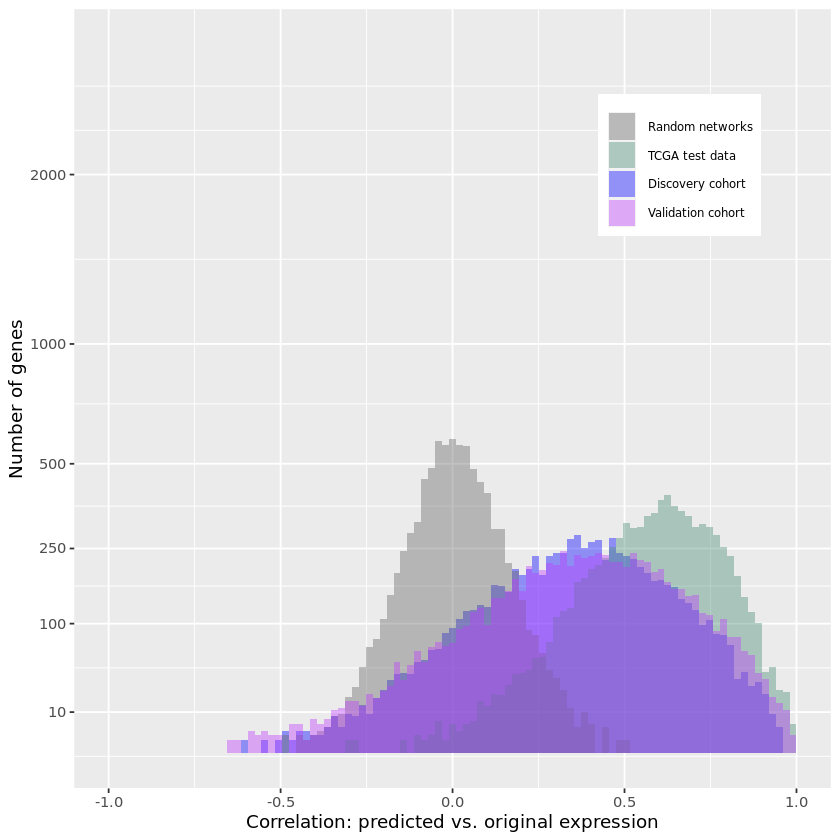

In [80]:
### random NW + TCGA test + MelBrain discovery + validation

wh = which(mergedPredResultsOwnNWNoNAmean$type %in% 
           c("Random networks","TCGA test data","Discovery cohort",
                                "Validation cohort"))
p1 = ggplot(data = mergedPredResultsOwnNWNoNAmean[wh,],
           mapping = aes(x=Correlation, fill=type)) + 
    geom_histogram(position="identity",alpha=0.4, bins = 100) + 
    scale_fill_manual(breaks =c("Random networks","TCGA test data","Discovery cohort",
                                "Validation cohort"),
                      values = c("#666666","aquamarine4","blue",
                                "darkorchid1")) +
    scale_y_sqrt(breaks=c(10,100,250,500,1000,2000), name="Number of genes", limits=c(0,3000))+
    scale_x_continuous( name="Correlation: predicted vs. original expression", limits=c(-1,1)) + 
    #theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=1)) + # axis labels perpendicular
    theme(legend.title=element_blank(), legend.position=c(.8,.8),legend.text=element_text(size=7),
          legend.spacing.x = unit(0.25, 'cm')) # more space between legend label and colored box
p1

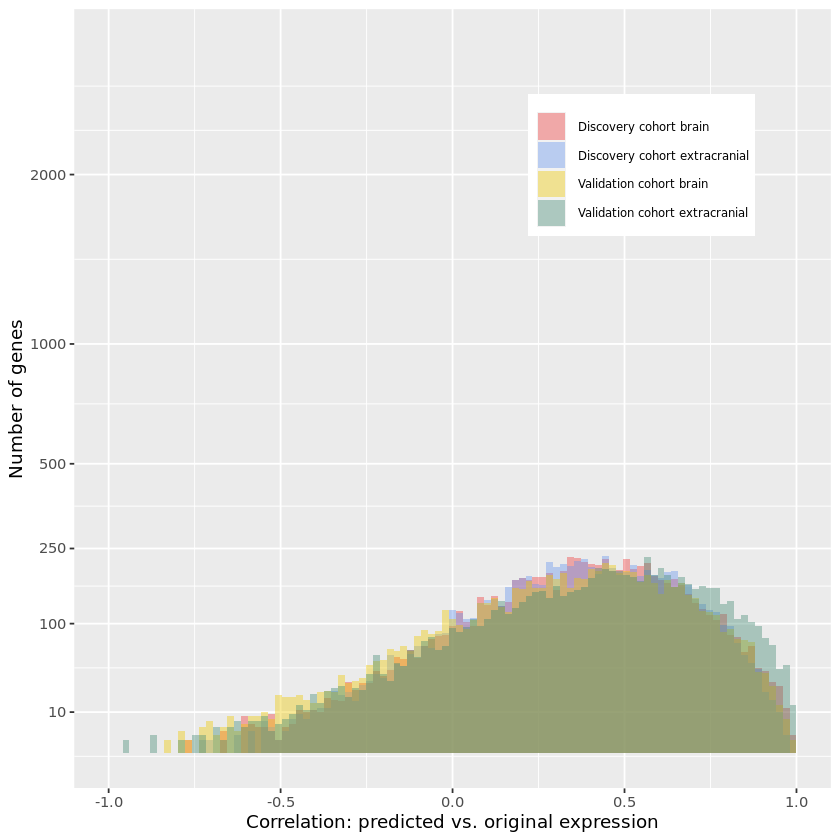

In [81]:
# now plot mean correlation between predicted and real gene expression

# discovery brain + ecm + validation brain + ecm

wh = which(mergedPredResultsOwnNWNoNAmean$type %in% 
           c("Discovery cohort brain", "Discovery cohort extracranial",
                               "Validation cohort brain", "Validation cohort extracranial"))

p2 = ggplot(data = mergedPredResultsOwnNWNoNAmean[wh,],
           mapping = aes(x=Correlation, fill=type)) + 
    geom_histogram(position="identity",alpha=0.4, bins = 100) + 
    scale_fill_manual(breaks = c("Discovery cohort brain", "Discovery cohort extracranial",
                                "Validation cohort brain", "Validation cohort extracranial"),
                      values = c("brown2", "cornflowerblue","gold2" , "aquamarine4")) +
    scale_y_sqrt(breaks=c(10,100,250,500,1000,2000), name="Number of genes", limits=c(0,3000))+
    scale_x_continuous( name="Correlation: predicted vs. original expression", limits=c(-1,1)) + 
    #labs(tag = "A") + theme(plot.tag.position = c(-0.5, 2000))  + 
    #theme(axis.text.x=element_text(angle=90,vjust=0.5,hjust=1)) + # axis labels perpendicular
    theme(legend.title=element_blank(), legend.position=c(.75,.8),legend.text=element_text(size=7),
          legend.spacing.x = unit(0.25, 'cm')) # more space between legend label and colored box
p2

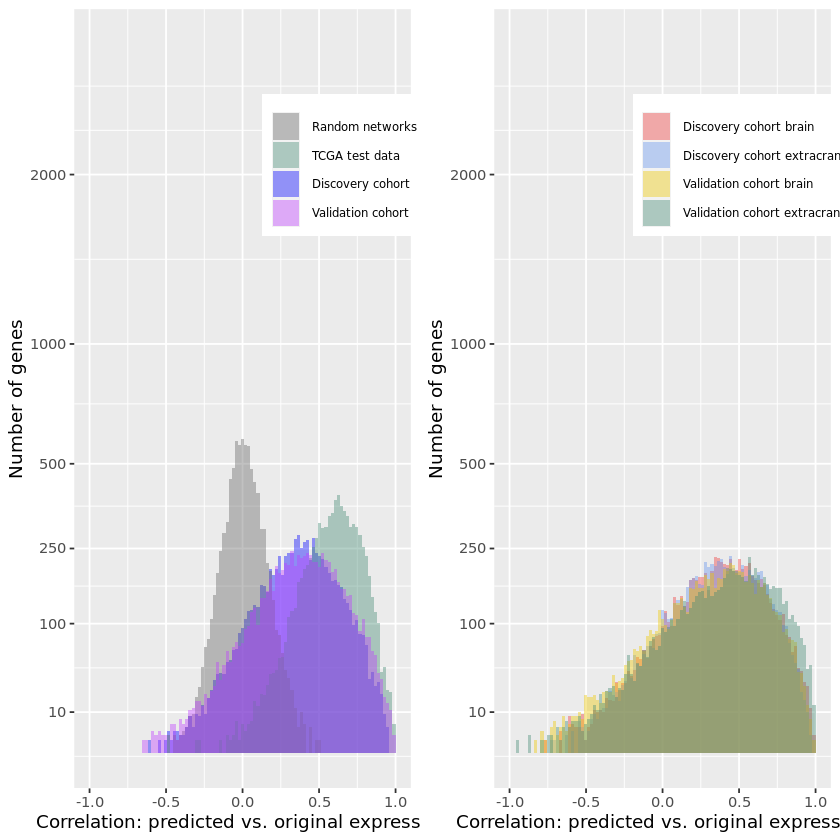

In [82]:
allplots = grid.arrange(p1,p2,nrow=1)

In [86]:
png(filename = paste0(outDirectory,"Figure-2-gene-expr-prediction-correl.png"),
    width = 4000,height = 1600, res=370)
plot(allplots)
dev.off()

png 
  2